# Função de suavização

In [1]:
from scipy.interpolate import interp1d
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def smooth_covid(Tx, x, w):
    # Convert datetime to numeric (timestamps)
    Tx_numeric = pd.to_datetime(Tx).astype(np.int64) // 10**9  # Convert to seconds since epoch

    # Identify indices where data is non-zero or non-null
    iz = np.where(np.diff(x) != 0)[0] + 1
    iz_first, iz_last = iz[0], iz[-1]
    
    Tz = Tx_numeric[iz]
    z = x[iz]

    # Interpolate with NaN handling
    interpolator = interp1d(Tz, z, kind='linear', fill_value="extrapolate")
    y_interp_NaN = interpolator(Tx_numeric)  # Apply interpolation on numeric datetime
    y_interp = np.copy(x)
    y_interp[iz_first:iz_last] = y_interp_NaN[iz_first:iz_last]

    # Smooth the interpolated data
    y_smoothed = pd.Series(y_interp).rolling(window=w, center=True).mean().to_numpy()
    
    return y_smoothed, y_interp, Tx, z

# Dados utilizados no gráfico

## Brasil.io
- estimated_population
- last_available_confirmed
- date

## Datasus
- populacaoTCU2019
- casosAcumulado
- data

# Investigacao e comparacao

In [2]:
datasus_df = pd.read_csv('datasus.csv', sep=';').sort_values(by='data')
datasus_df = datasus_df[(datasus_df['estado'] == 'MG') & (datasus_df['data'] >= '2020-03-08') & (datasus_df['municipio'].isna())].reset_index()
brasilio_df = pd.read_csv('MG.csv', sep=';').sort_values(by='date').reset_index()

In [3]:
brasilio_df = brasilio_df[brasilio_df['date'] <= datasus_df['data'].max()]

In [4]:
datasus_df[['data', 'populacaoTCU2019', 'casosNovos', 'casosAcumulado', 'municipio']].head(10)

,data,populacaoTCU2019,casosNovos,casosAcumulado,municipio
0,2020-03-08,21168791.0,1,1,NaN
1,2020-03-09,21168791.0,0,1,NaN
2,2020-03-10,21168791.0,0,1,NaN
3,2020-03-11,21168791.0,0,1,NaN
4,2020-03-12,21168791.0,0,1,NaN
5,2020-03-13,21168791.0,1,2,NaN
6,2020-03-14,21168791.0,0,2,NaN
7,2020-03-15,21168791.0,0,2,NaN
8,2020-03-16,21168791.0,3,5,NaN
9,2020-03-17,21168791.0,2,7,NaN


In [5]:
brasilio_df[['date', 'last_available_confirmed', 'estimated_population']].head(10)

,date,last_available_confirmed,estimated_population
0,2020-03-08,1,21292666
1,2020-03-09,1,21292666
2,2020-03-10,1,21292666
3,2020-03-11,1,21292666
4,2020-03-12,2,21292666
5,2020-03-13,2,21292666
6,2020-03-14,4,21292666
7,2020-03-15,4,21292666
8,2020-03-16,6,21292666
9,2020-03-17,14,21292666


Aqui vemos que para o dia 2020-03-17, temos **7** casos acumulados no datasus e no brasil.io temos **14**.

Isso já mostra que os dados não estão batendo.

## Diferença de populacao entre os dois datasets:

In [6]:
datasus_df.loc[0, 'populacaoTCU2019'] - brasilio_df.loc[0, 'estimated_population']

np.float64(-123875.0)

## Gráficos

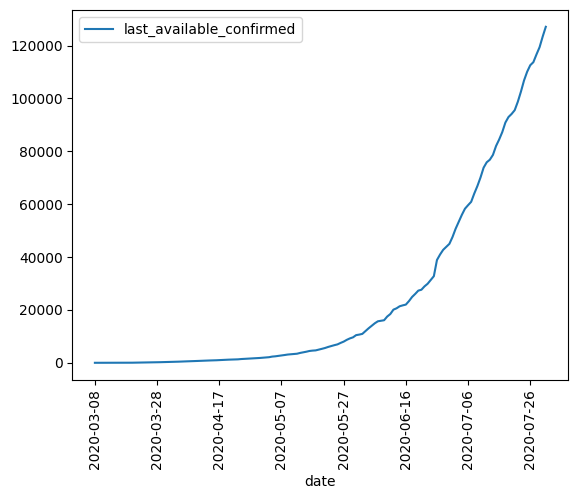

In [7]:
brasilio_df.plot(x='date', y='last_available_confirmed')
_ = plt.xticks(rotation=90)

Pelo formato da curva, percebemos que no dataset do brasil.io o last_available_confirmed seria o casoAcumulado do datasus.

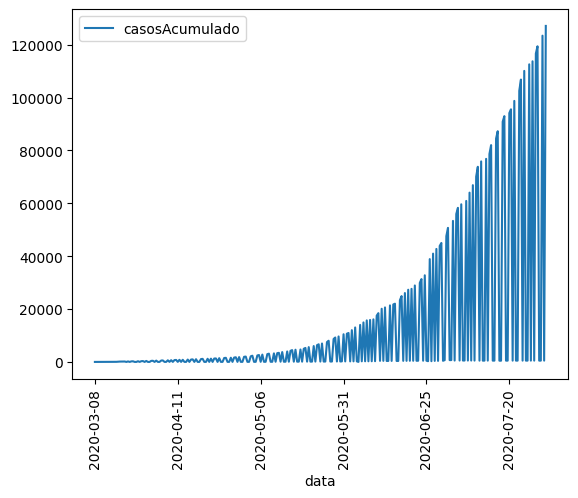

In [8]:
datasus_df[['casosAcumulado', 'data']].plot(x='data', y='casosAcumulado')
_ = plt.xticks(rotation=90)

# Dados suavizados pela função smooth_covid

# Datasus

## Com janela de 7 dias

<Axes: xlabel='data'>

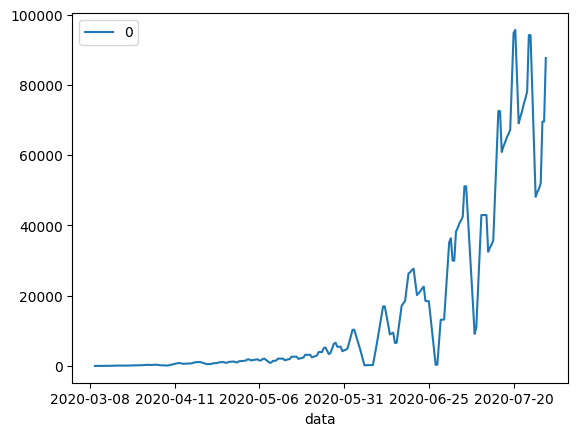

In [9]:
values, *_ = smooth_covid(datasus_df['data'].values, datasus_df['casosAcumulado'].values, 7)
pd.DataFrame(values, datasus_df['data']).plot()

## Com janela de 14 dias

<Axes: xlabel='data'>

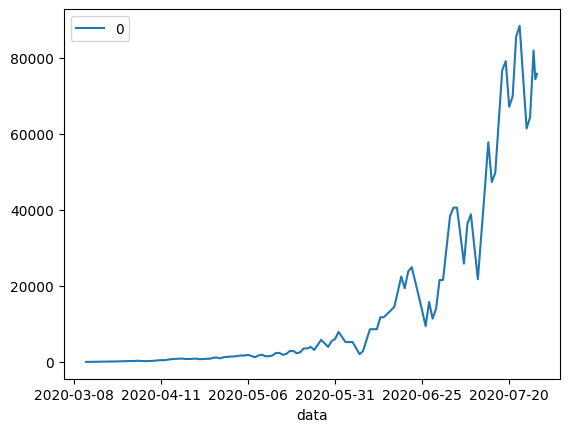

In [10]:
values, *_ = smooth_covid(datasus_df['data'].values, datasus_df['casosAcumulado'].values, 14)
pd.DataFrame(values, datasus_df['data']).plot()

## Com janela de 42 dias

<Axes: xlabel='data'>

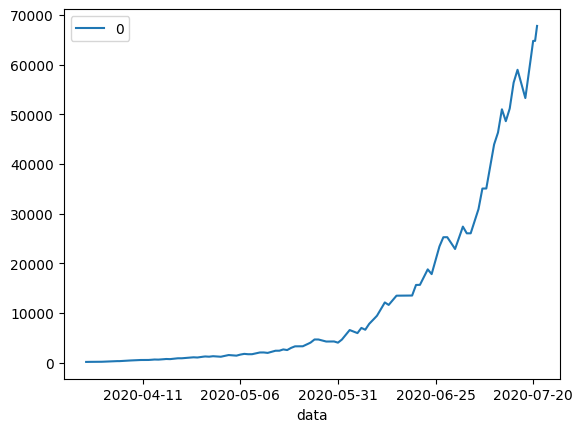

In [11]:
values, *_ = smooth_covid(datasus_df['data'].values, datasus_df['casosAcumulado'].values, 42)
pd.DataFrame(values, datasus_df['data']).plot()

## Brasil.io

<Axes: xlabel='date'>

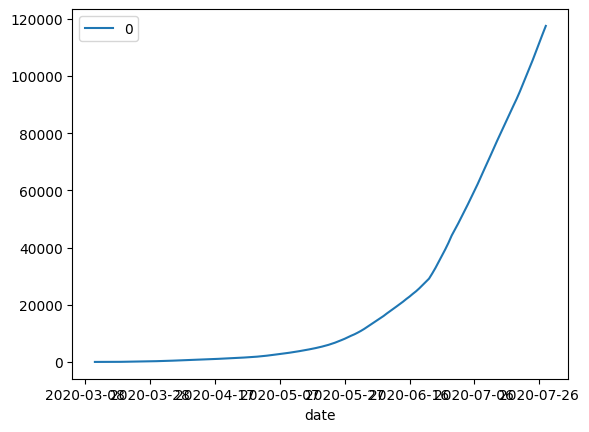

In [12]:
values, *_ = smooth_covid(brasilio_df['date'].values, brasilio_df['last_available_confirmed'].values, 7)
pd.DataFrame(values, brasilio_df['date']).plot()